
--- Training LSTM ---
[LSTM] Epoch 100/300, Train Loss=0.000700, Val Loss=0.000802
[LSTM] Epoch 200/300, Train Loss=0.000273, Val Loss=0.000339
[LSTM] Epoch 300/300, Train Loss=0.000211, Val Loss=0.000757
LSTM: Val MAPE=1.71%, Test MAPE=1.89%

--- Training GRU ---


/tmp/ipykernel_2627875/3563436460.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[GRU] Epoch 100/300, Train Loss=0.000673, Val Loss=0.001618
[GRU] Epoch 200/300, Train Loss=0.000173, Val Loss=0.000628
Early stopping triggered
[GRU] Early stopping at epoch 296
GRU: Val MAPE=1.67%, Test MAPE=1.93%

--- Training RNN ---


/tmp/ipykernel_2627875/3563436460.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[RNN] Epoch 100/300, Train Loss=0.001108, Val Loss=0.000369
[RNN] Epoch 200/300, Train Loss=0.000889, Val Loss=0.000221
[RNN] Epoch 300/300, Train Loss=0.000358, Val Loss=0.000210
RNN: Val MAPE=1.73%, Test MAPE=2.27%

--- Training CNN ---


/tmp/ipykernel_2627875/3563436460.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[CNN] Epoch 100/300, Train Loss=0.000339, Val Loss=0.001060
[CNN] Epoch 200/300, Train Loss=0.000997, Val Loss=0.002847
[CNN] Epoch 300/300, Train Loss=0.000462, Val Loss=0.000725
CNN: Val MAPE=2.57%, Test MAPE=2.28%

Summary of MAPE on Price:
  LSTM:  Val=1.71%, Test=1.89%
  GRU:  Val=1.67%, Test=1.93%
  RNN:  Val=1.73%, Test=2.27%
  CNN:  Val=2.57%, Test=2.28%


/tmp/ipykernel_2627875/3563436460.py:253: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


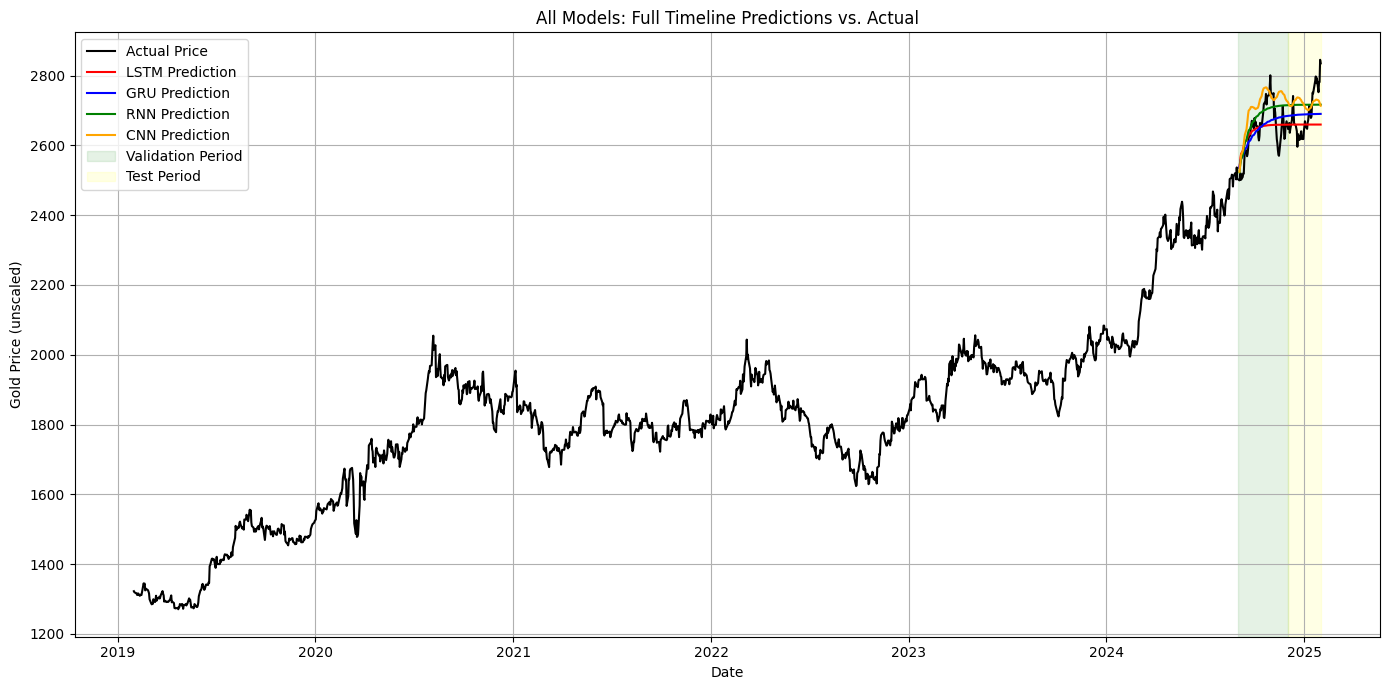

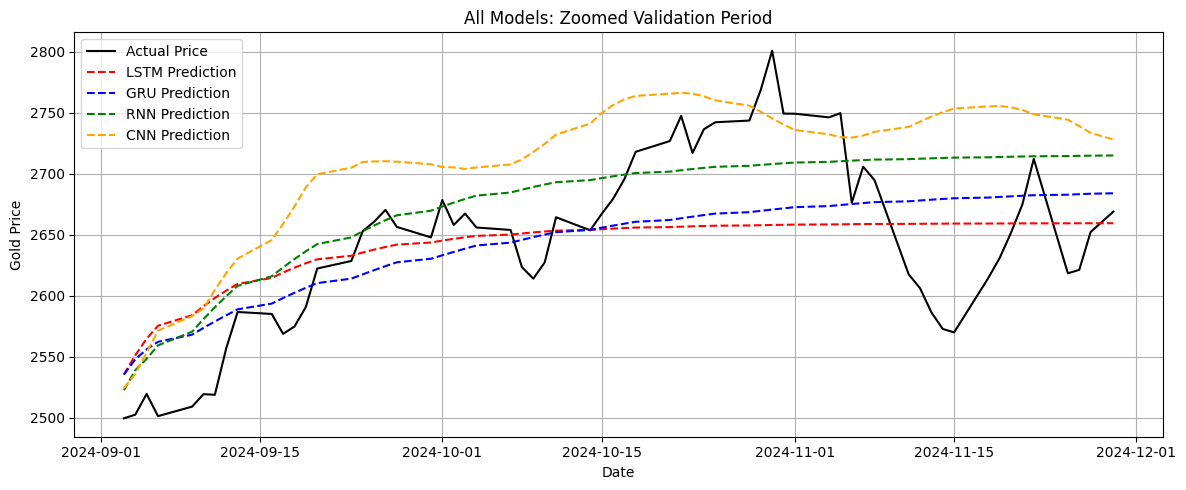

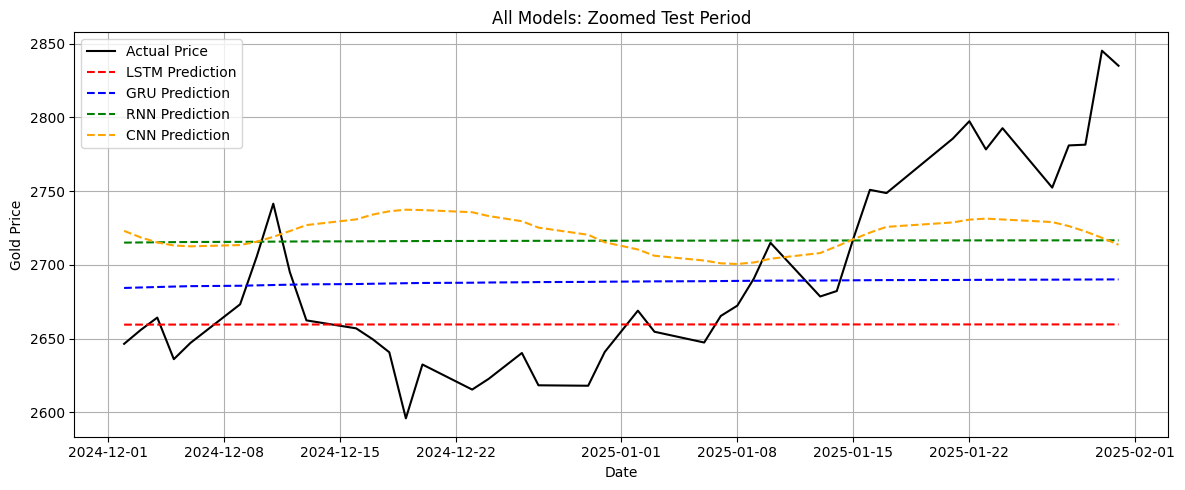

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings

# ------------------------------------------------------------------------
# 1. SET RANDOM SEEDS
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------------------------------------------------
# 2. LOAD AND PREPARE DATA
# ------------------------------------------------------------------------
df = pd.read_csv('Gold Futures Historical Data_5Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

num_cols = df.columns.drop('Date')
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Basic checks
#assert df.duplicated().sum() == 0, "Duplicate rows found!"
#assert df.isnull().sum().sum() == 0, "Missing values found!"

features = ['Price', 'Open', 'High', 'Low']
train_cutoff = pd.to_datetime('2024-09-01')
val_cutoff   = pd.to_datetime('2025-01-01')

df_train = df[df['Date'] < train_cutoff]
df_val   = df[(df['Date'] >= train_cutoff) & (df['Date'] < val_cutoff)]
df_test  = df[df['Date'] >= val_cutoff]

# ------------------------------------------------------------------------
# 3. SCALING ON TRAIN ONLY
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled[features] = scaler.transform(df_train[features])
df_val_scaled[features]   = scaler.transform(df_val[features])
df_test_scaled[features]  = scaler.transform(df_test[features])

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# ------------------------------------------------------------------------
# 4. BUILD (X, y) FOR TRAINING (and VAL) — Single-step, Multi-output
# ------------------------------------------------------------------------
window_width = 60

def make_sequences(df_subset, window=60):
    arr  = df_subset[features].values  # shape [N, 4]
    dts  = df_subset['Date'].values    # shape [N,]
    
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]   # shape [30,4]
        y_target = arr[i]               # shape [4, ] (Price,Open,High,Low)
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

X_train_all, y_train_all, train_dates_all = make_sequences(df_train_scaled, window_width)
X_val_all,   y_val_all,   val_dates_all   = make_sequences(df_val_scaled,   window_width)

X_train_tensor = torch.from_numpy(X_train_all).float()  # [N_train,30,4]
y_train_tensor = torch.from_numpy(y_train_all).float()  # [N_train,4]

X_val_tensor   = torch.from_numpy(X_val_all).float()    # [N_val,30,4]
y_val_tensor   = torch.from_numpy(y_val_all).float()    # [N_val,4]

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------------------
# 5. MODEL DEFINITIONS (Multi-output)
# ------------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super().__init__()
        self.model_type = model_type
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity='relu', dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            # Each conv reduces sequence length by (kernel_size-1)
            conv_out_len = window_width - 2*(3 - 1)
            self.fc = nn.Linear(128 * conv_out_len, 4)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        else:
            raise ValueError("Invalid model_type")
    
    def forward(self, x):
        if self.model_type == 'CNN':
            x = x.permute(0, 2, 1)  # (batch, 4, seq_len)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)       # [batch,seq,hidden]
            out = out[:, -1, :]       # final step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)        # [batch,4]
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]       # [batch, hidden]
            out = self.fc(out)        # [batch, 4]
        return out


class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------
# 6. INVERSE TRANSFORMS
#    We are predicting 4 columns. We'll invert them all at once.
# ------------------------------------------------------------------------
def inverse_transform_4cols(y_4):
    """
    y_4: (N,4) array of scaled [Price,Open,High,Low].
    Returns unscaled shape [N,4].
    """
    return scaler.inverse_transform(y_4)

def extract_price_col(y_4):
    """
    From array shape [N,4], return the Price column (index=0).
    """
    return y_4[:, 0]

# ------------------------------------------------------------------------
# 7. TRAIN MODEL
# ------------------------------------------------------------------------
def train_model(model_type='LSTM'):
    model = BaseModel(model_type).to(device)
    criterion = nn.MSELoss()  # or nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150, min_delta=0)

    num_epochs = 500
    best_val_loss = float('inf')
    best_path = f'best_model_{model_type}_5yr.pt'

    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"Loaded existing model for {model_type} from {best_path}")

    for epoch in range(num_epochs):
        # TRAIN
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)  # [batch,4]
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        # VALIDATION
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                val_out = model(Xb)
                val_loss = criterion(val_out, yb)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)

        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)
        
        # Save best
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_path)

        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}/{num_epochs}, "
                  f"Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # Load best model
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ------------------------------------------------------------------------
# 8. SINGLE WALK-FORWARD FROM VALIDATION START -> END OF TEST
#    Overwrite predictions in df_work for any day >= val_cutoff
# ------------------------------------------------------------------------
def walk_forward_predict_val_test(model, df_all_scaled, val_start, test_end, window=60):
    """
    model: trained, frozen multi-output model
    df_all_scaled: entire scaled DataFrame
    val_start: earliest validation date
    test_end: last date of the test period

    We do a single pass from val_start to test_end
    Overwriting Price/Open/High/Low for every day in [val_start, test_end].
    
    Returns a DataFrame with columns:
       Date,
       Pred_Price_scaled, Pred_Open_scaled, Pred_High_scaled, Pred_Low_scaled,
       Pred_Price_unscaled, ...
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values('Date', inplace=True)

    # We'll gather predictions in a list
    preds = []

    # All dates from val_start to test_end
    all_dates = df_work[(df_work['Date'] >= val_start) & (df_work['Date'] <= test_end)]['Date'].unique()
    all_dates = np.sort(all_dates)

    model.eval()
    with torch.no_grad():
        for d in all_dates:
            idx_current = df_work.index[df_work['Date'] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                # Not enough data for a 30-day window
                continue
            
            # Build the input window from df_work, which may already have predicted values for prior val/test days
            window_data = df_work.iloc[start_idx:idx_current][features].values  # shape [30,4]
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)  # [1,30,4]

            pred_4_scaled = model(X_input).cpu().numpy()[0]  # shape [4]
            # Overwrite the scaled features for date d
            df_work.loc[idx_current, features] = pred_4_scaled

            preds.append((d, *pred_4_scaled))

    pred_df = pd.DataFrame(preds, columns=[
        'Date',
        'Pred_Price_scaled','Pred_Open_scaled','Pred_High_scaled','Pred_Low_scaled'
    ])
    pred_df.sort_values('Date', inplace=True)

    # Inverse transform
    scaled_arr = pred_df[['Pred_Price_scaled','Pred_Open_scaled','Pred_High_scaled','Pred_Low_scaled']].values
    unscaled_arr = inverse_transform_4cols(scaled_arr)
    pred_df['Pred_Price_unscaled'] = unscaled_arr[:, 0]
    pred_df['Pred_Open_unscaled']  = unscaled_arr[:, 1]
    pred_df['Pred_High_unscaled']  = unscaled_arr[:, 2]
    pred_df['Pred_Low_unscaled']   = unscaled_arr[:, 3]

    return pred_df

# ------------------------------------------------------------------------
# 9. EVALUATION ON VAL AND TEST SLICES (MAPE on Price)
# ------------------------------------------------------------------------
def evaluate_predictions(pred_df):
    """
    pred_df: DataFrame with columns:
       Date, Pred_*_scaled, Pred_*_unscaled, etc.
    We'll merge with df_scaled to get the real scaled data,
    then slice for val, test, compute MAPE on Price.
    Returns dict with stats & also a merged DataFrame for plotting.
    """
    # Merge with real scaled data to find ground-truth
    # df_scaled has columns Date + [Price,Open,High,Low]
    merged = pd.merge(
        df_scaled[['Date','Price','Open','High','Low']], 
        pred_df, 
        on='Date', how='left'
    )
    merged.sort_values('Date', inplace=True)

    # Inverse transform real scaled [Price,Open,High,Low]
    # so we can get actual unscaled Price
    real_4_scaled = merged[['Price','Open','High','Low']].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    merged['Real_Price_unscaled'] = real_4_unscaled[:,0]
    merged['Real_Open_unscaled']  = real_4_unscaled[:,1]
    merged['Real_High_unscaled']  = real_4_unscaled[:,2]
    merged['Real_Low_unscaled']   = real_4_unscaled[:,3]

    # We'll define date-based slices for val & test
    # validation: [train_cutoff, val_cutoff) -> We want [val_cutoff_start, test_cutoff)
    val_mask  = (merged['Date'] >= train_cutoff) & (merged['Date'] <  val_cutoff)
    test_mask = (merged['Date'] >= val_cutoff)

    # We only compute metrics where we actually have predictions
    has_pred_mask = ~merged['Pred_Price_scaled'].isna()

    # Validation slice
    val_slice  = merged[val_mask & has_pred_mask]
    # Test slice
    test_slice = merged[test_mask & has_pred_mask]

    # MAPE on Price
    def compute_mape(slice_df):
        y_true = slice_df['Real_Price_unscaled'].values
        y_pred = slice_df['Pred_Price_unscaled'].values
        if len(y_true) == 0:
            return None
        return mean_absolute_percentage_error(y_true, y_pred)

    val_mape  = compute_mape(val_slice)
    test_mape = compute_mape(test_slice)

    return {
        'val_mape': val_mape,
        'test_mape': test_mape,
        'merged': merged  # for plotting
    }

# ------------------------------------------------------------------------
# 10. COMBINED PLOT FOR ALL MODELS
# ------------------------------------------------------------------------
def plot_all_models(all_results):
    """
    all_results: dict of {model_name: result_dict}, where result_dict['merged'] is
                 the DataFrame with columns Real_Price_unscaled, Pred_Price_unscaled, etc.
    We'll produce:
      - One big plot from the earliest date in merged to the end,
        overplot each model's predicted Price
      - We'll highlight val/test
      - We'll do separate zoom-in for val & test with all model lines
    """
    # 1. Build a single "real" timeline from df_scaled
    df_real = df_scaled[['Date','Price','Open','High','Low']].copy()
    df_real.sort_values('Date', inplace=True)
    real_unscaled = inverse_transform_4cols(df_real[features].values)
    df_real['Real_Price_unscaled'] = real_unscaled[:,0]

    # We'll store each model's predictions in a column for the full timeline
    # We'll do an outer merge on Date so we can align them
    # Start from df_real as a base
    for model_name, info in all_results.items():
        merged = info['merged']
        # We'll rename Pred_Price_unscaled -> e.g. Pred_Price_unscaled_{model_name}
        colname = f'Pred_Price_unscaled_{model_name}'
        # We'll do a left merge on df_real
        tmp = merged[['Date','Pred_Price_unscaled']].rename(columns={'Pred_Price_unscaled': colname})
        df_real = pd.merge(df_real, tmp, on='Date', how='left')

    # 2. Full Plot
    plt.figure(figsize=(14, 7))
    plt.plot(df_real['Date'], df_real['Real_Price_unscaled'], color='black', label='Actual Price')

    colors = {
        'LSTM': 'red',
        'GRU': 'blue',
        'RNN': 'green',
        'CNN': 'orange',
    }
    
    for model_name in all_results.keys():
        colname = f'Pred_Price_unscaled_{model_name}'
        plt.plot(
            df_real['Date'], df_real[colname],
            color=colors.get(model_name, 'gray'),
            linestyle='-',
            label=f'{model_name} Prediction'
        )

    # Highlight val/test
    plt.axvspan(train_cutoff, val_cutoff, color='green', alpha=0.1, label='Validation Period')
    plt.axvspan(val_cutoff, df_real['Date'].max(), color='yellow', alpha=0.1, label='Test Period')

    plt.title("All Models: Full Timeline Predictions vs. Actual")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 3. Zoomed-in: Validation period
    df_val_zoom = df_real[(df_real['Date'] >= train_cutoff) & (df_real['Date'] < val_cutoff)]

    plt.figure(figsize=(12, 5))
    plt.plot(df_val_zoom['Date'], df_val_zoom['Real_Price_unscaled'], color='black', label='Actual Price')
    for model_name in all_results.keys():
        colname = f'Pred_Price_unscaled_{model_name}'
        plt.plot(
            df_val_zoom['Date'], df_val_zoom[colname],
            color=colors.get(model_name, 'gray'),
            linestyle='--',
            label=f'{model_name} Prediction'
        )
    plt.title("All Models: Zoomed Validation Period")
    plt.xlabel("Date")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4. Zoomed-in: Test period
    df_test_zoom = df_real[df_real['Date'] >= val_cutoff]

    plt.figure(figsize=(12, 5))
    plt.plot(df_test_zoom['Date'], df_test_zoom['Real_Price_unscaled'], color='black', label='Actual Price')
    for model_name in all_results.keys():
        colname = f'Pred_Price_unscaled_{model_name}'
        plt.plot(
            df_test_zoom['Date'], df_test_zoom[colname],
            color=colors.get(model_name, 'gray'),
            linestyle='--',
            label=f'{model_name} Prediction'
        )
    plt.title("All Models: Zoomed Test Period")
    plt.xlabel("Date")
    plt.ylabel("Gold Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# ------------------------------------------------------------------------
# 11. MAIN: TRAIN MULTIPLE MODELS, SINGLE CONTINUOUS WALK-FORWARD, PLOT
# ------------------------------------------------------------------------
if __name__ == "__main__":
    model_types = ['LSTM', 'GRU', 'RNN', 'CNN']
    all_results = {}

    for mt in model_types:
        print(f"\n--- Training {mt} ---")
        model = train_model(mt)

        # Single walk-forward from earliest validation day (train_cutoff) to the end of test
        # We'll make sure we start walk-forward at the earliest day we consider "blind."
        # That is the day we want to begin overwriting with predictions.
        pred_df = walk_forward_predict_val_test(
            model,
            df_all_scaled=df_scaled,
            val_start=train_cutoff,   # Overwrite from the first val day onward
            test_end=df['Date'].max(),  # up to last date in entire dataset
            window=window_width
        )

        # Evaluate on validation slice [train_cutoff, val_cutoff) and test slice [val_cutoff, end]
        info = evaluate_predictions(pred_df)
        val_mape  = info['val_mape']
        test_mape = info['test_mape']

        if val_mape is None:
            val_mape_pct = "N/A"
        else:
            val_mape_pct = f"{val_mape * 100:.2f}%"

        if test_mape is None:
            test_mape_pct = "N/A"
        else:
            test_mape_pct = f"{test_mape * 100:.2f}%"

        print(f"{mt}: Val MAPE={val_mape_pct}, Test MAPE={test_mape_pct}")

        # Save
        info['pred_df'] = pred_df  # raw predictions table
        all_results[mt] = info

    # Summaries
    print("\nSummary of MAPE on Price:")
    for mt in model_types:
        vmap = all_results[mt]['val_mape']
        tmap = all_results[mt]['test_mape']
        vstr = f"{vmap*100:.2f}%" if vmap is not None else "N/A"
        tstr = f"{tmap*100:.2f}%" if tmap is not None else "N/A"
        print(f"  {mt}:  Val={vstr}, Test={tstr}")

    # Plot all models on one set of charts
    plot_all_models(all_results)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings

# ------------------------------------------------------------------------
# 1. Set random seeds for reproducibility
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------------------------------------------------
# 2. Load and clean data
# ------------------------------------------------------------------------
df = pd.read_csv('Gold Futures Historical Data_5Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

num_cols = df.columns.drop('Date')
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Basic checks
#assert df.duplicated().sum() == 0, "Duplicates found!"
#assert df.isnull().sum().sum() == 0, "Missing data found!"

# We treat 4 columns as features to predict: Price, Open, High, Low
features = ['Price', 'Open', 'High', 'Low']

# ------------------------------------------------------------------------
# 3. Define date cutoffs: TRAIN, VAL, TEST
#    - The model can see actual validation data for parameter tuning,
#      but once we hit the test start date, we remain blind to real test data.
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime('2024-11-01')
test_cutoff  = pd.to_datetime('2025-01-10')  # begin test

df_train = df[df['Date'] < train_cutoff]
df_val   = df[(df['Date'] >= train_cutoff) & (df['Date'] < test_cutoff)]
df_test  = df[df['Date'] >= test_cutoff]

# ------------------------------------------------------------------------
# 4. Fit MinMaxScaler on TRAIN data only
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled[features] = scaler.transform(df_train[features])
df_val_scaled[features]   = scaler.transform(df_val[features])
df_test_scaled[features]  = scaler.transform(df_test[features])

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# ------------------------------------------------------------------------
# 5. Build (X, y) for TRAIN and VAL sets (SINGLE-step approach)
# ------------------------------------------------------------------------
window_width = 30

def make_sequences(df_subset, window=30):
    arr = df_subset[features].values  # shape [N,4]
    dts = df_subset['Date'].values    # shape [N,]
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]   # [30,4]
        y_target = arr[i]               # [4,] (Price,Open,High,Low)
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

X_train_all, y_train_all, train_dates_all = make_sequences(df_train_scaled, window_width)
X_val_all,   y_val_all,   val_dates_all   = make_sequences(df_val_scaled,   window_width)

X_train_tensor = torch.from_numpy(X_train_all).float()  # [N_train,30,4]
y_train_tensor = torch.from_numpy(y_train_all).float()  # [N_train,4]

X_val_tensor   = torch.from_numpy(X_val_all).float()    # [N_val,30,4]
y_val_tensor   = torch.from_numpy(y_val_all).float()    # [N_val,4]

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor,   y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ------------------------------------------------------------------------
# 6. Define a multi-output model class (predicting 4 features)
# ------------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super().__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)  # 4 outputs
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity='relu', dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_out_len = window_width - 2*(3-1)  # each conv reduces seq_length
            self.fc = nn.Linear(128*conv_out_len, 4)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        else:
            raise ValueError("Invalid model_type")

    def forward(self, x):
        # x shape: [batch, 30, 4]
        if self.model_type == 'CNN':
            # (batch,seq_len,channels) -> (batch,channels,seq_len)
            x = x.permute(0,2,1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)  # [batch,4]
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)       # [batch,seq_len,hidden]
            out = out[:, -1, :]       # last step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)        # [batch,4]
        else:
            out, _ = self.rnn(x)      # [batch,seq_len,hidden]
            out = out[:, -1, :]       # last step
            out = self.fc(out)        # [batch,4]
        return out

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------
# 7. Helper for inverse transform
# ------------------------------------------------------------------------
def inverse_transform_4cols(y_4):
    """y_4: shape [N,4] scaled -> unscaled [Price,Open,High,Low]"""
    return scaler.inverse_transform(y_4)

def extract_price(y_4):
    """From shape [N,4], get Price (column 0)."""
    return y_4[:,0]

# ------------------------------------------------------------------------
# 8. Train the model (train+val single-step). Model sees actual val data
#    to compute val loss and do early stopping. Then we freeze it.
# ------------------------------------------------------------------------
def train_model(model_type='LSTM'):
    model = BaseModel(model_type).to(device)
    criterion = nn.MSELoss()  # or nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150)

    num_epochs = 800
    best_val_loss = float('inf')
    best_path = f'best_{model_type}_5yr.pt'

    # If you have a checkpoint, optionally load it
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"Loaded existing model weights from {best_path}")

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)  # [batch,4]
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        # Validation
        model.eval()
        val_losses = []
        with torch.no_grad():
            for Xb, yb in val_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                val_out = model(Xb)
                val_loss = criterion(val_out, yb)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)

        scheduler.step(avg_val_loss)
        early_stopping(avg_val_loss)

        # Save best
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), best_path)

        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, "
                  f"Train Loss={avg_train_loss:.6f}, Val Loss={avg_val_loss:.6f}")

    # Load best weights
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ------------------------------------------------------------------------
# 9. Multi-step walk-forward forecasting on TEST ONLY
#    The model sees actual data for any day < test_cutoff
#    but if a prior day is in test range, we use that day’s predicted data.
# ------------------------------------------------------------------------
def walk_forward_test(model, df_all_scaled, test_start, window=30):
    """
    model: trained & frozen
    df_all_scaled: entire scaled DataFrame (train+val+test)
    test_start: first date of the test set
    window: 30 days
    Returns a DataFrame with predicted Price (scaled + unscaled) for test days.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values('Date', inplace=True)

    # We'll gather predictions for each day in the test
    preds = []

    # All test dates in ascending order
    test_dates = df_work[df_work['Date'] >= test_start]['Date'].unique()
    test_dates = np.sort(test_dates)

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            # index of the current day
            idx_current = df_work.index[df_work['Date'] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]

            start_idx = idx_current - window
            if start_idx < 0:
                continue

            # Build 30-day window from df_work
            # If any day in [start_idx, idx_current-1] is >= test_start,
            # that row's Price/Open/High/Low might be predicted from a prior step.
            window_data = df_work.iloc[start_idx:idx_current][features].values  # [30,4]
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)

            y_pred_4_scaled = model(X_input).cpu().numpy()[0]  # shape [4]
            # Overwrite today's [Price,Open,High,Low] with predicted scaled
            df_work.loc[idx_current, features] = y_pred_4_scaled

            preds.append((d, y_pred_4_scaled[0], y_pred_4_scaled[1],
                             y_pred_4_scaled[2], y_pred_4_scaled[3]))

    # Build a DataFrame of predicted scaled features
    pred_df = pd.DataFrame(preds, columns=[
        'Date',
        'Pred_Price_scaled','Pred_Open_scaled','Pred_High_scaled','Pred_Low_scaled'
    ])
    pred_df.sort_values('Date', inplace=True)

    # Inverse transform
    scaled_array = pred_df[['Pred_Price_scaled','Pred_Open_scaled',
                            'Pred_High_scaled','Pred_Low_scaled']].values
    unscaled_array = inverse_transform_4cols(scaled_array)
    pred_df['Pred_Price_unscaled'] = unscaled_array[:,0]
    pred_df['Pred_Open_unscaled']  = unscaled_array[:,1]
    pred_df['Pred_High_unscaled']  = unscaled_array[:,2]
    pred_df['Pred_Low_unscaled']   = unscaled_array[:,3]

    return pred_df

# ------------------------------------------------------------------------
# 10. Evaluate on test set (Price MAPE) and produce a combined plot
# ------------------------------------------------------------------------
def evaluate_and_plot_all_models(results_dict):
    """
    results_dict = {
      model_name: {
        'pred_df': DataFrame of predictions for test set,
        'MAPE': ...
      },
      ...
    }
    We'll produce one plot with all models' predictions vs. actual Price on the test set.
    We'll highlight the train and val periods, too.
    """
    # We want to compare predictions vs. actual Price
    # 1) Build a base DataFrame for the entire timeline with real Price
    df_real = df_scaled[['Date','Price','Open','High','Low']].copy()
    df_real.sort_values('Date', inplace=True)
    # Inverse transform real scaled 4 features to get real Price unscaled
    real_4_scaled = df_real[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real['Real_Price_unscaled'] = real_4_unscaled[:,0]

    # 2) For each model, merge test predictions (unscaled Price) with df_real
    #    We'll store them as new columns
    for model_name, info in results_dict.items():
        pred_df = info['pred_df']
        tmp = pred_df[['Date','Pred_Price_unscaled']].copy()
        newcol = f'Pred_{model_name}'
        tmp.rename(columns={'Pred_Price_unscaled': newcol}, inplace=True)
        df_real = pd.merge(df_real, tmp, on='Date', how='left')

    # 3) Single figure with all model lines on test region + real entire
    plt.figure(figsize=(14,7))
    # Plot real Price across entire timeline
    plt.plot(df_real['Date'], df_real['Real_Price_unscaled'], color='black', label='Actual Price')

    color_map = {
        'LSTM': 'red',
        'GRU': 'blue',
        'RNN': 'green',
        'CNN': 'orange',
    }

    for model_name in results_dict.keys():
        col = f'Pred_{model_name}'
        plt.plot(
            df_real['Date'],
            df_real[col],
            color=color_map.get(model_name,'gray'),
            linestyle='-',
            label=f'{model_name} (Test Prediction)'
        )

    # highlight train/val/test
    plt.axvspan(df_train['Date'].min(), train_cutoff, color='skyblue', alpha=0.1, label='Train Period')
    plt.axvspan(train_cutoff, test_cutoff, color='green', alpha=0.1, label='Val Period')
    plt.axvspan(test_cutoff, df_real['Date'].max(), color='yellow', alpha=0.1, label='Test Period')

    plt.title("All Models: Test Predictions vs Actual Price\n(No Actual Price seen in test by any model)")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 4) Zoom in on test period only
    df_test_zoom = df_real[df_real['Date'] >= test_cutoff]
    plt.figure(figsize=(12,5))
    plt.plot(df_test_zoom['Date'], df_test_zoom['Real_Price_unscaled'], color='black', label='Actual Price')
    for model_name in results_dict.keys():
        col = f'Pred_{model_name}'
        plt.plot(
            df_test_zoom['Date'],
            df_test_zoom[col],
            color=color_map.get(model_name,'gray'),
            linestyle='--',
            label=f'{model_name} Prediction'
        )
    plt.title("Test Period Zoom-in")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# 11. MAIN - Train multiple models, freeze, do multi-step test, measure MAPE, final plots
# ------------------------------------------------------------------------
if __name__ == "__main__":
    model_types = ['LSTM', 'GRU', 'RNN', 'CNN']
    results_dict = {}

    # Train and evaluate each model type
    for mt in model_types:
        print(f"\n=== Training {mt} model ===")
        model = train_model(mt)

        # Once trained, do a multi-step walk-forward on the test set only
        # The model sees actual data up to test_cutoff-1. From test_cutoff day onward,
        # any prior test day uses predicted features.
        pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=window_width
        )

        # Evaluate MAPE on test set Price
        # Merge with real test data
        df_test_eval = pd.merge(
            df_test_scaled[['Date','Price','Open','High','Low']],
            pred_df,
            on='Date', how='left'
        )
        df_test_eval.dropna(subset=['Pred_Price_scaled'], inplace=True)

        # Real scaled Price -> unscaled
        y_test_true_4_scaled = df_test_eval[['Price','Open','High','Low']].values
        y_test_true_4_unscaled = inverse_transform_4cols(y_test_true_4_scaled)
        y_test_true_price_unscaled = extract_price(y_test_true_4_unscaled)

        y_test_pred_price_unscaled = df_test_eval['Pred_Price_unscaled'].values

        # MAPE
        mape = mean_absolute_percentage_error(y_test_true_price_unscaled, y_test_pred_price_unscaled)
        print(f"{mt} Test MAPE on Price: {mape*100:.2f}%")

        # Store
        results_dict[mt] = {
            'pred_df': pred_df,  # predictions over entire test
            'MAPE': mape
        }

    # Print summary
    print("\n--- Summary of Test MAPE (Price) ---")
    for mt in model_types:
        print(f"{mt}: {results_dict[mt]['MAPE']*100:.2f}%")

    # Plot all models on one figure
    evaluate_and_plot_all_models(results_dict)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings

# ------------------------------------------------------------------------
# 1. Set random seeds for reproducibility
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

# ------------------------------------------------------------------------
# 2. Load and clean data
# ------------------------------------------------------------------------
df = pd.read_csv('Gold Futures Historical Data_5Yr.csv')
df.drop(['Vol.', 'Change %'], axis=1, inplace=True)

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

num_cols = df.columns.drop('Date')
df[num_cols] = df[num_cols].replace({',': ''}, regex=True).astype('float64')

# Basic checks (uncomment if needed)
# assert df.duplicated().sum() == 0, "Duplicates found!"
# assert df.isnull().sum().sum() == 0, "Missing data found!"

# We treat 4 columns as features to predict: Price, Open, High, Low
features = ['Price', 'Open', 'High', 'Low']

# ------------------------------------------------------------------------
# 3. Define date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime('2024-11-01')
test_cutoff  = pd.to_datetime('2025-01-15')  # begin test

df_train = df[df['Date'] < train_cutoff]
df_val   = df[(df['Date'] >= train_cutoff) & (df['Date'] < test_cutoff)]
df_test  = df[df['Date'] >= test_cutoff]

# ------------------------------------------------------------------------
# 4. Fit MinMaxScaler on TRAIN data only
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled[features] = scaler.transform(df_train[features])
df_val_scaled[features]   = scaler.transform(df_val[features])
df_test_scaled[features]  = scaler.transform(df_test[features])

# For convenience, combine into one DataFrame (scaled),
# but remember the scaler only learned from train!
df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

# ------------------------------------------------------------------------
# 5A. Build (X, y) for TRAIN set (as before) -- single-step, entire train
# ------------------------------------------------------------------------
window_width = 25

def make_sequences(df_subset, window=25):
    arr = df_subset[features].values  # shape [N,4]
    dts = df_subset['Date'].values    # shape [N,]
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]   # [30,4]
        y_target = arr[i]                # [4,]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

X_train_all, y_train_all, train_dates_all = make_sequences(df_train_scaled, window_width)

X_train_tensor = torch.from_numpy(X_train_all).float()  # [N_train,30,4]
y_train_tensor = torch.from_numpy(y_train_all).float()    # [N_train,4]

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

# ------------------------------------------------------------------------
# 5B. "Half-blind" walk-forward for the VALIDATION set
#
# For each validation day d in [train_cutoff, test_cutoff):
#   1) Build the 30-day window using ACTUAL data for all days < d.
#   2) Predict day d (blind).
#   3) Compare prediction with the actual day d.
#   4) Keep the actual day d in the data so that the next day sees real data.
# ------------------------------------------------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=30):
    """Returns the average MSE over the validation days using a half-blind walk-forward.
    The model uses real (unmodified) data for all days prior to day d, predicts d,
    and then day d remains the actual data for future predictions.
    """
    df_work = df_scaled.copy()
    df_work.sort_values('Date', inplace=True)

    # Get all validation dates in sorted order.
    val_mask = (df_work['Date'] >= val_start) & (df_work['Date'] < val_end)
    val_dates = df_work.loc[val_mask, 'Date'].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    criterion = nn.MSELoss()
    losses = []
    
    with torch.no_grad():
        for d in val_dates:
            # Find the index for the current day d.
            idx_current = df_work.index[df_work['Date'] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]

            # Check if we have enough history (window days) prior to d.
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            # Build input window from df_work (which has real data for all days before d).
            window_data = df_work.iloc[start_idx:idx_current][features].values  # shape [30,4]
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)

            # Predict day d (scaled)
            pred_4_scaled = model(X_input).cpu()  # shape [1,4]
            pred_4_scaled = pred_4_scaled[0]       # shape [4]

            # IMPORTANT: Convert the true data to a numeric type.
            true_4_scaled = torch.tensor(
                df_scaled.loc[idx_current, features].values.astype(np.float64)
            ).float()

            loss = criterion(pred_4_scaled, true_4_scaled)
            losses.append(loss.item())

            # "Uncover" day d by keeping its actual data intact.
            # (No replacement with predicted values here.)
    if len(losses) == 0:
        return 9999  # If no validation data available.
    return np.mean(losses)

# ------------------------------------------------------------------------
# 6. Define a multi-output model class (predicting 4 features)
# ------------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type='LSTM'):
        super().__init__()
        self.model_type = model_type
        
        if model_type == 'LSTM':
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)  # 4 outputs
        elif model_type == 'GRU':
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == 'RNN':
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity='relu', dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == 'CNN':
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)
            conv_out_len = window_width - 2*(3-1)  # each conv reduces sequence length
            self.fc = nn.Linear(128*conv_out_len, 4)
        elif model_type == 'EnhancedLSTM':
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        else:
            raise ValueError("Invalid model_type")

    def forward(self, x):
        # x shape: [batch, 30, 4]
        if self.model_type == 'CNN':
            # Rearrange shape: (batch, seq_len, channels) -> (batch, channels, seq_len)
            x = x.permute(0, 2, 1)
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)  # shape: [batch, 4]
        elif self.model_type == 'EnhancedLSTM':
            out, _ = self.rnn(x)       # shape: [batch, seq_len, hidden]
            out = out[:, -1, :]        # take last step
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)         # shape: [batch, 4]
        else:
            out, _ = self.rnn(x)       # shape: [batch, seq_len, hidden]
            out = out[:, -1, :]        # last time step
            out = self.fc(out)         # shape: [batch, 4]
        return out

class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------
# 7. Helper for inverse transform
# ------------------------------------------------------------------------
def inverse_transform_4cols(y_4):
    """Convert scaled features [Price,Open,High,Low] to unscaled values."""
    return scaler.inverse_transform(y_4)

def extract_price(y_4):
    """Extract Price (first column) from a [N,4] array."""
    return y_4[:, 0]

# ------------------------------------------------------------------------
# 8. Train the model
#    - Training uses mini-batches from the training set.
#    - Validation uses the half-blind walk-forward approach.
# ------------------------------------------------------------------------
def train_model(model_type='LSTM'):
    model = BaseModel(model_type).to(device)
    criterion = nn.MSELoss()  # or use nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=150)
    early_stopping = EarlyStopping(patience=150)

    num_epochs = 300
    best_val_loss = float('inf')
    best_path = f'best_{model_type}_5yr_Full_Blind_V2.pt'

    # Optionally load checkpoint if it exists
    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"Loaded existing model weights from {best_path}")

    for epoch in range(num_epochs):
        # ---------------------------
        # Training Phase
        # ---------------------------
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)  # shape: [batch, 4]
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        # ---------------------------
        # Validation Phase (half-blind walk-forward)
        # ---------------------------
        val_loss = half_blind_validation_loss(
            model,
            df_scaled,       # full scaled DataFrame (train+val+test)
            val_start=train_cutoff,
            val_end=test_cutoff,
            window=window_width
        )

        scheduler.step(val_loss)
        early_stopping(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, "
                  f"Train Loss = {avg_train_loss:.6f}, Val Loss = {val_loss:.6f}")

    # Load best model weights before returning
    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ------------------------------------------------------------------------
# 9. Multi-step walk-forward forecasting on TEST ONLY (fully blind)
#
# Once test period begins, if any day in the input window is in test,
# its features have been replaced by predicted values from previous steps.
# ------------------------------------------------------------------------
def walk_forward_test(model, df_all_scaled, test_start, window=30):
    """
    model: trained & frozen model.
    df_all_scaled: full scaled DataFrame (train+val+test).
    test_start: first date of the test set.
    window: window width (default 30).
    Returns a DataFrame with predicted scaled and unscaled prices for test days.
    """
    df_work = df_all_scaled.copy()
    df_work.sort_values('Date', inplace=True)

    preds = []  # to hold predictions

    # Get all test dates in order
    test_dates = df_work[df_work['Date'] >= test_start]['Date'].unique()
    test_dates = np.sort(test_dates)

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work['Date'] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]

            start_idx = idx_current - window
            if start_idx < 0:
                continue

            # Build window from df_work; note: some days in the window might be predictions.
            window_data = df_work.iloc[start_idx:idx_current][features].values  # shape [30,4]
            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)

            y_pred_4_scaled = model(X_input).cpu().numpy()[0]  # shape [4]

            # Overwrite today's features with the prediction (for multi-step forecasting)
            df_work.loc[idx_current, features] = y_pred_4_scaled

            preds.append((d, *y_pred_4_scaled))

    # Create a DataFrame of predictions (scaled)
    pred_df = pd.DataFrame(
        preds,
        columns=['Date',
                 'Pred_Price_scaled', 'Pred_Open_scaled', 'Pred_High_scaled', 'Pred_Low_scaled']
    )
    pred_df.sort_values('Date', inplace=True)

    # Inverse transform to get unscaled predictions
    scaled_array = pred_df[['Pred_Price_scaled', 'Pred_Open_scaled', 'Pred_High_scaled', 'Pred_Low_scaled']].values
    unscaled_array = inverse_transform_4cols(scaled_array)
    pred_df['Pred_Price_unscaled'] = unscaled_array[:, 0]
    pred_df['Pred_Open_unscaled']  = unscaled_array[:, 1]
    pred_df['Pred_High_unscaled']  = unscaled_array[:, 2]
    pred_df['Pred_Low_unscaled']   = unscaled_array[:, 3]

    return pred_df

# ------------------------------------------------------------------------
# 10. Evaluate on test set (Price MAPE) and plot results
# ------------------------------------------------------------------------
def evaluate_and_plot_all_models(results_dict):
    """
    results_dict = {
      model_name: {
        'pred_df': DataFrame of predictions for test set,
        'MAPE': ...
      },
      ...
    }
    Produces plots of predictions vs. actual Price.
    """
    # Build a base DataFrame with actual prices (unscaled)
    df_real = df_scaled[['Date', 'Price', 'Open', 'High', 'Low']].copy()
    df_real.sort_values('Date', inplace=True)
    real_4_scaled = df_real[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real['Real_Price_unscaled'] = real_4_unscaled[:, 0]

    # Merge each model's predictions into df_real
    for model_name, info in results_dict.items():
        pred_df = info['pred_df']
        tmp = pred_df[['Date', 'Pred_Price_unscaled']].copy()
        newcol = f'Pred_{model_name}'
        tmp.rename(columns={'Pred_Price_unscaled': newcol}, inplace=True)
        df_real = pd.merge(df_real, tmp, on='Date', how='left')

    plt.figure(figsize=(14, 7))
    plt.plot(df_real['Date'], df_real['Real_Price_unscaled'], color='black', label='Actual Price')

    color_map = {
        'LSTM': 'red',
        'GRU': 'blue',
        'RNN': 'green',
        'CNN': 'orange',
        'EnhancedLSTM': 'magenta'
    }

    for model_name in results_dict.keys():
        col = f'Pred_{model_name}'
        plt.plot(
            df_real['Date'],
            df_real[col],
            color=color_map.get(model_name, 'gray'),
            linestyle='-',
            label=f'{model_name} (Test Pred)'
        )

    # Highlight train/val/test periods
    plt.axvspan(df_train['Date'].min(), train_cutoff, color='skyblue', alpha=0.1, label='Train')
    plt.axvspan(train_cutoff, test_cutoff, color='green', alpha=0.1, label='Validation')
    plt.axvspan(test_cutoff, df_real['Date'].max(), color='yellow', alpha=0.1, label='Test')

    plt.title("All Models: Test Predictions vs Actual Price")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Zoom in on the test period
    df_test_zoom = df_real[df_real['Date'] >= test_cutoff]
    plt.figure(figsize=(12, 5))
    plt.plot(df_test_zoom['Date'], df_test_zoom['Real_Price_unscaled'], color='black', label='Actual Price')
    for model_name in results_dict.keys():
        col = f'Pred_{model_name}'
        plt.plot(
            df_test_zoom['Date'],
            df_test_zoom[col],
            color=color_map.get(model_name, 'gray'),
            linestyle='--',
            label=f'{model_name} Prediction'
        )
    plt.title("Test Period Zoom-in")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ------------------------------------------------------------------------
# 11. MAIN - Train multiple models, perform test forecasts, and plot results
# ------------------------------------------------------------------------
if __name__ == "__main__":
    model_types = ['LSTM', 'GRU', 'RNN', 'CNN']  # You can add 'EnhancedLSTM' if desired
    results_dict = {}

    for mt in model_types:
        print(f"\n=== Training {mt} model ===")
        model = train_model(mt)

        # Fully blind multi-step forecasting on the test set.
        pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=window_width
        )

        # Evaluate MAPE on test set Price
        df_test_eval = pd.merge(
            df_test_scaled[['Date', 'Price', 'Open', 'High', 'Low']],
            pred_df,
            on='Date', how='left'
        )
        df_test_eval.dropna(subset=['Pred_Price_scaled'], inplace=True)

        y_test_true_4_scaled = df_test_eval[['Price', 'Open', 'High', 'Low']].values
        y_test_true_4_unscaled = inverse_transform_4cols(y_test_true_4_scaled)
        y_test_true_price_unscaled = extract_price(y_test_true_4_unscaled)

        y_test_pred_price_unscaled = df_test_eval['Pred_Price_unscaled'].values
        mape = mean_absolute_percentage_error(y_test_true_price_unscaled, y_test_pred_price_unscaled)
        print(f"{mt} Test MAPE on Price: {mape*100:.2f}%")

        results_dict[mt] = {
            'pred_df': pred_df,
            'MAPE': mape
        }

    print("\n--- Summary of Test MAPE (Price) ---")
    for mt in model_types:
        print(f"{mt}: {results_dict[mt]['MAPE']*100:.2f}%")

    evaluate_and_plot_all_models(results_dict)


CSV date range:
  Min date: 2021-01-04 00:00:00
  Max date: 2025-01-31 00:00:00
Number of rows in df: 1051
Rows that have all features = NaN: 21
TRAIN rows: 966
VAL   rows: 64
TEST  rows: 21

=== Training LSTM model ===
[LSTM] Epoch 100, Train=0.000508, Val=0.001885
[LSTM] Epoch 200, Train=0.000324, Val=0.001240
[LSTM] Epoch 300, Train=0.000767, Val=0.001007
[LSTM] Epoch 400, Train=0.000224, Val=0.000611
Early stopping triggered
[LSTM] Early stopping at epoch 452
LSTM has no real test data => skip MAPE

=== Training GRU model ===


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[GRU] Epoch 100, Train=0.000348, Val=0.000921
[GRU] Epoch 200, Train=0.000222, Val=0.002124
Early stopping triggered
[GRU] Early stopping at epoch 255
GRU has no real test data => skip MAPE

=== Training RNN model ===


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[RNN] Epoch 100, Train=0.000600, Val=0.002405
[RNN] Epoch 200, Train=0.000480, Val=0.000577
[RNN] Epoch 300, Train=0.000460, Val=0.000432
[RNN] Epoch 400, Train=0.001557, Val=0.000580
[RNN] Epoch 500, Train=0.000297, Val=0.000464
RNN has no real test data => skip MAPE

=== Training CNN model ===


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


[CNN] Epoch 100, Train=0.000401, Val=0.005511
[CNN] Epoch 200, Train=0.001500, Val=0.009630
Early stopping triggered
[CNN] Early stopping at epoch 274
CNN has no real test data => skip MAPE


/tmp/ipykernel_3239407/1434472731.py:401: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=device))


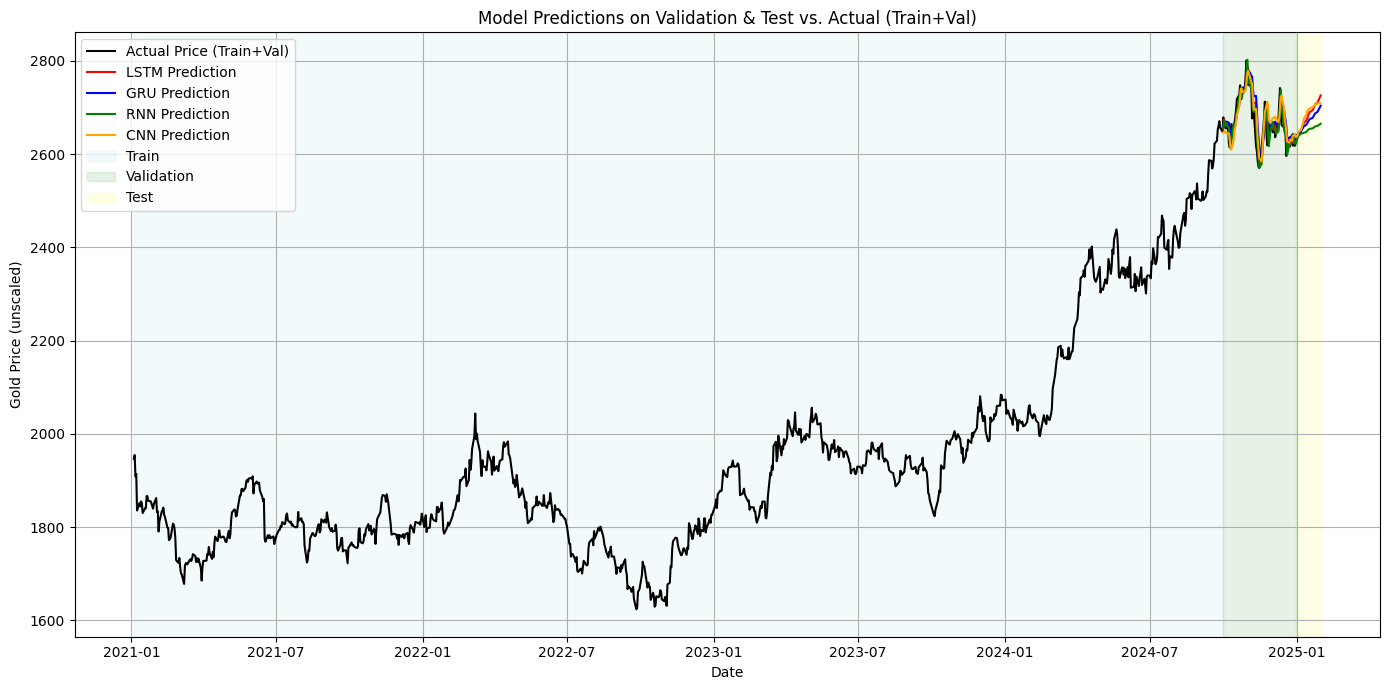

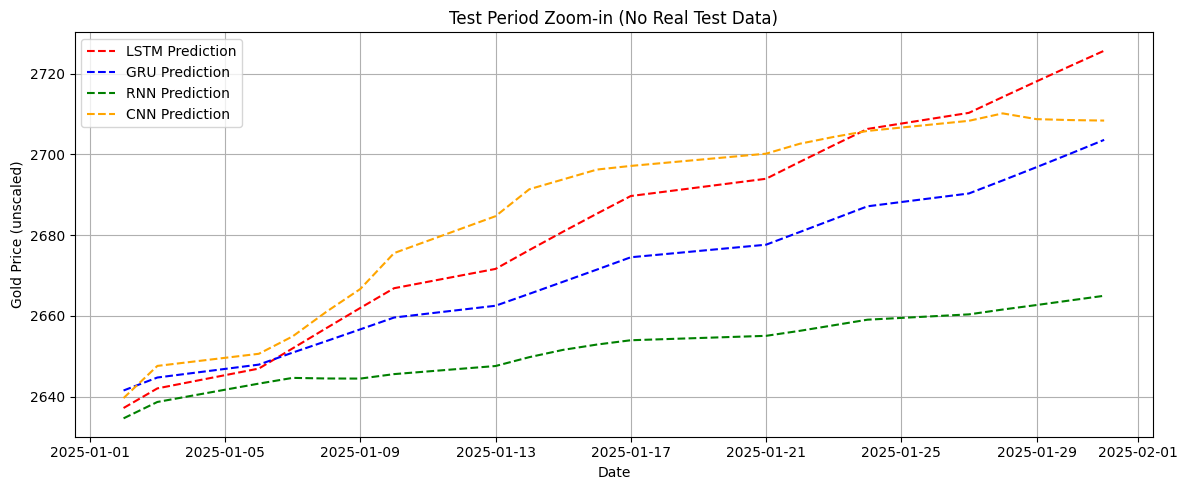

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import os
import random
import warnings
from sklearn.metrics import mean_absolute_percentage_error

# ------------------------------------------------------------------------
# 1. Set random seeds
# ------------------------------------------------------------------------
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

###############################################################
# Global hyperparameters
###############################################################
# You can change these two variables in one place.

WINDOW_SIZE = 30
NUM_EPOCHS  = 500

###############################################################
# Explanation:
# The key fix is in the CNN branch: we must compute the conv
# output length dynamically from 'WINDOW_SIZE' rather than
# hard-coding 30.
###############################################################

# ------------------------------------------------------------------------
# 2. Load & Clean CSV
# ------------------------------------------------------------------------
features = ["Price", "Open", "High", "Low"]
csv_file = "Gold Futures Historical Data_5Yr_Blind Test.csv"

df = pd.read_csv(csv_file)

# Convert Date to datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop columns we don't need
df.drop(columns=["Vol.", "Change %"], errors="ignore", inplace=True)

# Remove commas and parse numeric
for col in features:
    if col not in df.columns:
        df[col] = np.nan
    else:
        df[col] = df[col].astype(str).str.replace(",", "", regex=True)
        df[col] = pd.to_numeric(df[col], errors="coerce")

df.sort_values(by="Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("CSV date range:")
print("  Min date:", df["Date"].min())
print("  Max date:", df["Date"].max())
print("Number of rows in df:", len(df))
print("Rows that have all features = NaN:",
      df[features].isna().all(axis=1).sum())

# ------------------------------------------------------------------------
# 3. Date cutoffs: TRAIN, VAL, TEST
# ------------------------------------------------------------------------
train_cutoff = pd.to_datetime("2024-10-01")
val_cutoff   = pd.to_datetime("2024-12-31")
test_cutoff  = pd.to_datetime("2025-01-02")

df_train = df[df["Date"] < train_cutoff].copy()
df_val   = df[(df["Date"] >= train_cutoff) & (df["Date"] <= val_cutoff)].copy()
df_test  = df[df["Date"] >= test_cutoff].copy()

print(f"TRAIN rows: {len(df_train)}")
print(f"VAL   rows: {len(df_val)}")
print(f"TEST  rows: {len(df_test)}")

df_train_nonan = df_train.dropna(subset=features)
if df_train_nonan.empty:
    raise ValueError("No valid numeric feature rows in the training set...")

# ------------------------------------------------------------------------
# 4. Fit MinMaxScaler on TRAIN only
# ------------------------------------------------------------------------
scaler = MinMaxScaler()
scaler.fit(df_train_nonan[features])

df_train_scaled = df_train.copy()
df_val_scaled   = df_val.copy()
df_test_scaled  = df_test.copy()

df_train_scaled.loc[df_train_nonan.index, features] = scaler.transform(df_train_nonan[features])

df_val_no_nan = df_val_scaled.dropna(subset=features)
if not df_val_no_nan.empty:
    df_val_scaled.loc[df_val_no_nan.index, features] = scaler.transform(df_val_no_nan[features])

train_mins = df_train_nonan[features].min()
df_test_filled = df_test_scaled[features].fillna(train_mins)
df_test_scaled.loc[:, features] = scaler.transform(df_test_filled)

df_scaled = pd.concat([df_train_scaled, df_val_scaled, df_test_scaled], ignore_index=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------------------------------
# 5A. Create the training sequences
# ------------------------------------------------------------------------
def make_sequences(df_subset, window=WINDOW_SIZE):
    arr = df_subset[features].values
    dts = df_subset["Date"].values
    X_list, y_list, date_list = [], [], []
    for i in range(window, len(arr)):
        X_window = arr[i - window : i]
        y_target = arr[i]
        X_list.append(X_window)
        y_list.append(y_target)
        date_list.append(dts[i])
    return np.array(X_list), np.array(y_list), np.array(date_list)

# Build training data
# only use scaled rows that have non-NaN features

train_scaled_no_nan = df_train_scaled.dropna(subset=features)
X_train_all, y_train_all, train_dates_all = make_sequences(train_scaled_no_nan, window=WINDOW_SIZE)

X_train_tensor = torch.from_numpy(X_train_all).float()
y_train_tensor = torch.from_numpy(y_train_all).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# ------------------------------------------------------------------------
# 5B. "Half-blind" validation function
# (We do not store predictions here, only compute loss)
# We'll add a separate function below to store validation predictions.
# ------------------------------------------------------------------------
def half_blind_validation_loss(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    criterion = nn.MSELoss()

    losses = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu()[0]

            true_vals = df_work.loc[idx_current, features]
            true_vals = pd.to_numeric(true_vals, errors="coerce").astype(float)
            true_vals = true_vals.values
            if np.isnan(true_vals).any():
                continue

            loss = criterion(pred_4_scaled, torch.tensor(true_vals).float())
            losses.append(loss.item())

    if len(losses) == 0:
        return 999999.0
    return np.mean(losses)

# ------------------------------------------------------------------------
# 5C. "Half-blind" validation predictions (to visualize model in val set)
# We'll not overwrite the DataFrame, so we remain half-blind.
# ------------------------------------------------------------------------
def half_blind_validation_preds(model, df_scaled, val_start, val_end, window=WINDOW_SIZE):
    """Return a DataFrame of day-by-day predictions for the validation set."""
    df_work = df_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []  # store day, predicted scaled[4]

    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]

            # We do NOT overwrite day d with predictions (half-blind)
            # We just store them.
            preds.append((d, *pred_4_scaled))

    # Build a DataFrame
    val_pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Val_Pred_Price_scl", "Val_Pred_Open_scl",
                 "Val_Pred_High_scl",  "Val_Pred_Low_scl"]
    )
    val_pred_df.sort_values("Date", inplace=True)
    # Inverse transform
    scaled_array = val_pred_df[["Val_Pred_Price_scl", "Val_Pred_Open_scl",
                                "Val_Pred_High_scl",  "Val_Pred_Low_scl"]].values
    unscaled_array = scaler.inverse_transform(scaled_array)

    val_pred_df["Val_Pred_Price_unsc"] = unscaled_array[:,0]
    val_pred_df["Val_Pred_Open_unsc"]  = unscaled_array[:,1]
    val_pred_df["Val_Pred_High_unsc"]  = unscaled_array[:,2]
    val_pred_df["Val_Pred_Low_unsc"]   = unscaled_array[:,3]

    return val_pred_df

# ------------------------------------------------------------------------
# 6. Define the model class with dynamic CNN out-len
# ------------------------------------------------------------------------
class BaseModel(nn.Module):
    def __init__(self, model_type="LSTM", window_width=WINDOW_SIZE):
        super().__init__()
        self.model_type = model_type
        self.window_width = window_width

        if model_type == "CNN":
            # Two conv layers, kernel_size=3 (no padding, stride=1)
            self.conv1 = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=3)
            self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3)

            # Dynamically compute the output dimension after the conv layers:
            # Create a dummy input of shape [batch_size, channels, seq_length]
            with torch.no_grad():
                dummy_input = torch.zeros(1, 4, self.window_width)
                dummy_output = self.conv2(F.relu(self.conv1(dummy_input)))
                # Flatten all dimensions except batch: (channels * seq_length)
                conv_output_size = dummy_output.shape[1] * dummy_output.shape[2]
            self.fc = nn.Linear(conv_output_size, 4)

        elif model_type == "LSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=2,
                               batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "GRU":
            self.rnn = nn.GRU(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "RNN":
            self.rnn = nn.RNN(input_size=4, hidden_size=128, num_layers=2,
                              batch_first=True, nonlinearity="relu", dropout=0.1)
            self.fc = nn.Linear(128, 4)
        elif model_type == "EnhancedLSTM":
            self.rnn = nn.LSTM(input_size=4, hidden_size=128, num_layers=3,
                               batch_first=True, dropout=0.2)
            self.bn = nn.BatchNorm1d(128)
            self.dropout = nn.Dropout(0.2)
            self.fc = nn.Linear(128, 4)
        else:
            raise ValueError("Invalid model_type")

    def forward(self, x):
        # x: [batch, window_width, 4]
        if self.model_type == "CNN":
            x = x.permute(0, 2, 1)  # [batch, channels=4, seq_len=window_width]
            x = F.relu(self.conv1(x))
            x = F.relu(self.conv2(x))
            x = x.view(x.size(0), -1)
            out = self.fc(x)
        elif self.model_type == "EnhancedLSTM":
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.bn(out)
            out = self.dropout(out)
            out = self.fc(out)
        else:
            out, _ = self.rnn(x)
            out = out[:, -1, :]
            out = self.fc(out)
        return out


class EarlyStopping:
    def __init__(self, patience=150, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# ------------------------------------------------------------------------
# 7. Inverse transform helper
# ------------------------------------------------------------------------
def inverse_transform_4cols(y_4):
    return scaler.inverse_transform(y_4)

# ------------------------------------------------------------------------
# 8. Training function
# ------------------------------------------------------------------------
def train_model(model_type="LSTM", num_epochs=NUM_EPOCHS):
    """
    Builds a model of the chosen type with window=WINDOW_SIZE,
    trains for num_epochs, and returns the best model.
    """
    model = BaseModel(model_type, window_width=WINDOW_SIZE).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=0.0005)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=150)
    early_stopping = EarlyStopping(patience=150)

    best_val_loss = float("inf")
    best_path = f"best_{model_type}_TotalBlind_V1.pt"

    if os.path.exists(best_path):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            model.load_state_dict(torch.load(best_path, map_location=device))
        print(f"[{model_type}] Loaded existing model from {best_path}")

    for epoch in range(num_epochs):
        # Train
        model.train()
        train_losses = []
        for Xb, yb in train_loader:
            Xb, yb = Xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(Xb)
            loss = criterion(out, yb)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)

        # Validate (compute half-blind loss)
        val_loss = half_blind_validation_loss(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        scheduler.step(val_loss)
        early_stopping(val_loss)

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

        if early_stopping.early_stop:
            print(f"[{model_type}] Early stopping at epoch {epoch+1}")
            break

        if (epoch + 1) % 100 == 0:
            print(f"[{model_type}] Epoch {epoch+1}, Train={avg_train_loss:.6f}, Val={val_loss:.6f}")

    model.load_state_dict(torch.load(best_path, map_location=device))
    return model

# ------------------------------------------------------------------------
# 9. Validation predictions + Test predictions
#    We do separate walk-forward for val (half-blind, no overwrite)
#    and test (fully-blind, overwrite) to get final predictions.
# ------------------------------------------------------------------------
def half_blind_validation_preds_df(model, df_all_scaled, val_start, val_end, window=WINDOW_SIZE):
    """Get day-by-day half-blind predictions for the validation set."""
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    val_mask = (df_work["Date"] >= val_start) & (df_work["Date"] <= val_end)
    val_dates = df_work.loc[val_mask, "Date"].unique()
    val_dates = np.sort(val_dates)

    model.eval()
    preds = []
    with torch.no_grad():
        for d in val_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            pred_4_scaled = model(X_input).cpu().numpy()[0]

            preds.append((d, *pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    # inverse transform
    scl_array = pred_df[["Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]].values
    unsc_array = inverse_transform_4cols(scl_array)
    pred_df["Pred_Price_unscaled"] = unsc_array[:, 0]
    pred_df["Pred_Open_unscaled"]  = unsc_array[:, 1]
    pred_df["Pred_High_unscaled"]  = unsc_array[:, 2]
    pred_df["Pred_Low_unscaled"]   = unsc_array[:, 3]

    return pred_df


def walk_forward_test(model, df_all_scaled, test_start, window=WINDOW_SIZE):
    """Fully-blind multi-step forecast on test (overwrite)"""
    df_work = df_all_scaled.copy()
    df_work.sort_values("Date", inplace=True)

    preds = []
    test_dates = df_work[df_work["Date"] >= test_start]["Date"].unique()
    test_dates = np.sort(test_dates)

    model.eval()
    with torch.no_grad():
        for d in test_dates:
            idx_current = df_work.index[df_work["Date"] == d]
            if len(idx_current) == 0:
                continue
            idx_current = idx_current[0]
            start_idx = idx_current - window
            if start_idx < 0:
                continue

            window_df = df_work.iloc[start_idx:idx_current][features]
            window_df = window_df.apply(pd.to_numeric, errors="coerce").astype(float)
            window_data = window_df.values
            if np.isnan(window_data).any():
                continue

            X_input = torch.from_numpy(window_data).float().unsqueeze(0).to(device)
            y_pred_4_scaled = model(X_input).cpu().numpy()[0]

            # Overwrite day d
            df_work.loc[idx_current, features] = y_pred_4_scaled
            preds.append((d, *y_pred_4_scaled))

    pred_df = pd.DataFrame(
        preds,
        columns=["Date", "Pred_Price_scaled", "Pred_Open_scaled", "Pred_High_scaled", "Pred_Low_scaled"]
    )
    pred_df.sort_values("Date", inplace=True)

    # inverse transform
    scaled_array = pred_df[["Pred_Price_scaled","Pred_Open_scaled","Pred_High_scaled","Pred_Low_scaled"]].values
    unscaled_array = inverse_transform_4cols(scaled_array)
    pred_df["Pred_Price_unscaled"] = unscaled_array[:,0]
    pred_df["Pred_Open_unscaled"]  = unscaled_array[:,1]
    pred_df["Pred_High_unscaled"]  = unscaled_array[:,2]
    pred_df["Pred_Low_unscaled"]   = unscaled_array[:,3]

    return pred_df

# ------------------------------------------------------------------------
# 10. Evaluate & Plot
# ------------------------------------------------------------------------
def evaluate_and_plot_all_models(results_dict):
    df_real = df_scaled[["Date","Price","Open","High","Low"]].copy()
    df_real.sort_values("Date", inplace=True)

    # Inverse transform real Price only up to test
    mask_trainval = (df_real["Date"] < test_cutoff)
    df_real_plot = df_real.loc[mask_trainval].copy()
    real_4_scaled = df_real_plot[features].values
    real_4_unscaled = inverse_transform_4cols(real_4_scaled)
    df_real_plot["Real_Price_unscaled"] = real_4_unscaled[:,0]

    # We'll merge each model's val+test predictions into the same col "Pred_{model}"

    plt.figure(figsize=(14,7))

    # Plot real Price (train+val only)
    plt.plot(df_real_plot["Date"], df_real_plot["Real_Price_unscaled"],
             color="black", label="Actual Price (Train+Val)")

    color_map = {
        "LSTM": "red",
        "GRU": "blue",
        "RNN": "green",
        "CNN": "orange",
        "EnhancedLSTM": "magenta"
    }

    for model_name, info in results_dict.items():
        # we already merged them below, but let's do it systematically.
        pass

    # Because we want to see final merged df, let's do the merges now.
    merged_df = df_real.copy()
    merged_df.sort_values("Date", inplace=True)

    for model_name, info in results_dict.items():
        # We have 'val_pred_df' (validation) and 'test_pred_df' (test)
        val_pred_df = info["val_pred_df"]
        test_pred_df = info["test_pred_df"]

        # unify them into single column: "Pred_{model_name}"
        # We'll create a combined pred_df.
        frames = []
        if val_pred_df is not None:
            frames.append(val_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if test_pred_df is not None:
            frames.append(test_pred_df.rename(columns={
                "Pred_Price_unscaled": f"Pred_{model_name}",
            }))
        if not frames:
            # no predictions?
            continue
        combined_df = pd.concat(frames, ignore_index=True)
        combined_df = combined_df[["Date", f"Pred_{model_name}"]].copy()
        combined_df.drop_duplicates("Date", keep="last", inplace=True)
        combined_df.sort_values("Date", inplace=True)

        merged_df = pd.merge(merged_df, combined_df, on="Date", how="left")

    # Now we can plot the final columns.
    for model_name, info in results_dict.items():
        col = f"Pred_{model_name}"
        if col in merged_df.columns:
            plt.plot(
                merged_df["Date"],
                merged_df[col],
                color=color_map.get(model_name,"gray"),
                linestyle="-",
                label=f"{model_name} Prediction"
            )

    # highlight regions
    plt.axvspan(df_train["Date"].min(), train_cutoff, color="skyblue", alpha=0.1, label="Train")
    plt.axvspan(train_cutoff, val_cutoff, color="green", alpha=0.1, label="Validation")
    plt.axvspan(test_cutoff, merged_df["Date"].max(), color="yellow", alpha=0.1, label="Test")

    plt.title("Model Predictions on Validation & Test vs. Actual (Train+Val)")
    plt.xlabel("Date")
    plt.ylabel("Gold Price (unscaled)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Zoom in on test portion if you like
    df_test_zoom = merged_df[merged_df["Date"] >= test_cutoff]
    if not df_test_zoom.empty:
        plt.figure(figsize=(12,5))
        # We do NOT plot real Price in test, as user requested
        for model_name, info in results_dict.items():
            col = f"Pred_{model_name}"
            if col in df_test_zoom.columns:
                plt.plot(
                    df_test_zoom["Date"],
                    df_test_zoom[col],
                    color=color_map.get(model_name,"gray"),
                    linestyle="--",
                    label=f"{model_name} Prediction"
                )

        plt.title("Test Period Zoom-in (No Real Test Data)")
        plt.xlabel("Date")
        plt.ylabel("Gold Price (unscaled)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# ------------------------------------------------------------------------
# 11. MAIN
# ------------------------------------------------------------------------
if __name__ == "__main__":
    model_types = ["LSTM", "GRU", "RNN", "CNN"]
    results_dict = {}

    for mt in model_types:
        print(f"\n=== Training {mt} model ===")
        model = train_model(mt, num_epochs=NUM_EPOCHS)

        # We'll produce predictions for val & test.
        val_pred_df = half_blind_validation_preds_df(
            model,
            df_scaled,
            val_start=train_cutoff,
            val_end=val_cutoff,
            window=WINDOW_SIZE
        )
        # rename columns to unify
        val_pred_df.rename(columns={
            "Pred_Price_unscaled":    "Pred_Price_unscaled",
        }, inplace=True)

        test_pred_df = walk_forward_test(
            model,
            df_all_scaled=df_scaled,
            test_start=test_cutoff,
            window=WINDOW_SIZE
        )

        # store in results
        results_dict[mt] = {
            "val_pred_df": val_pred_df,
            "test_pred_df": test_pred_df
        }
        print(f"{mt} has no real test data => skip MAPE")

    evaluate_and_plot_all_models(results_dict)